In [87]:
import yaml
def load_yaml_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
config = load_yaml_config('config/config.yaml')

In [88]:
import os
import yaml
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,3'
import torch

from torch.utils.data import DataLoader, random_split, Dataset, Subset

from data_loader import HDF5Dataset


In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 


# Load data
variables_to_load = ['ppt', 'tmin', 'tmax']
dataset = HDF5Dataset(config['h5_file'], variables_to_load, config['labels_path'], 2000, 2009, sequence_length=1)
dataset_size = len(dataset) 

In [90]:
num_train = int(0.8 * len(dataset))
num_val = int(0.1 * len(dataset))
num_test = len(dataset) - num_train - num_val
train_indices = range(0, num_train)
val_indices   = range(num_train, num_train + num_val)
test_indices  = range(num_train + num_val, dataset_size)
train_dataset = Subset(dataset, train_indices)
val_dataset   = Subset(dataset, val_indices)
test_dataset  = Subset(dataset, test_indices)

In [91]:
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=32)

In [92]:
import torch

all_ppt  = []
all_tmin = []
all_tmax = []

for batch_idx, data_dict in enumerate(test_loader):
    # Each data_dict is like {'ppt': (B, 1, H, W), 'tmin': (B, 1, H, W), 'tmax': (B, 1, H, W), 'label': ...}
    # Typically B=1 if each day is a separate batch. If B>1, it means multiple days in one batch.

    ppt_batch  = data_dict['ppt']   # shape: (B, 1, H, W)
    tmin_batch = data_dict['tmin']  # shape: (B, 1, H, W)
    tmax_batch = data_dict['tmax']  # shape: (B, 1, H, W)

    # Remove the single "channel/time" dimension
    # shape -> (B, H, W)
    ppt_batch  = ppt_batch.squeeze(1)
    tmin_batch = tmin_batch.squeeze(1)
    tmax_batch = tmax_batch.squeeze(1)

    # Store them
    all_ppt.append(ppt_batch)
    all_tmin.append(tmin_batch)
    all_tmax.append(tmax_batch)

# Concatenate along the "day" dimension
# If each day is B=1, after cat -> shape is (num_days, H, W)
ppt_all  = torch.cat(all_ppt,  dim=0)
tmin_all = torch.cat(all_tmin, dim=0)
tmax_all = torch.cat(all_tmax, dim=0)

print("ppt_all shape: ",  ppt_all.shape)   # (num_days, H, W)
print("tmin_all shape: ", tmin_all.shape)  # (num_days, H, W)
print("tmax_all shape: ", tmax_all.shape)  # (num_days, H, W)


ppt_all shape:  torch.Size([365, 1849, 1458])
tmin_all shape:  torch.Size([365, 1849, 1458])
tmax_all shape:  torch.Size([365, 1849, 1458])


In [93]:
import numpy as np

# Suppose 'data' is a NumPy array with shape (365, 1849, 1458).
# Step 1: Move the 'days' dimension to the end, so each pixel has a 1D time series
ppt_transposed = np.transpose(ppt_all, (1, 2, 0))  # shape: (1849, 1458, 365)
tmin_transposed = np.transpose(tmin_all, (1, 2, 0))  # shape: (1849, 1458, 365)
tmax_transposed = np.transpose(tmax_all, (1, 2, 0))  # shape: (1849, 1458, 365)

# Step 2: Flatten the spatial dims into one dimension
H, W, T = ppt_transposed.shape  # H=1849, W=1458, T=365
ppt_flat = ppt_transposed.reshape(H * W, T)   # shape: (1849*1458, 365)
tmin_flat = tmin_transposed.reshape(H * W, T)   # shape: (1849*1458, 365)
tmax_flat = tmax_transposed.reshape(H * W, T)   # shape: (1849*1458, 365)

print("data_flat shape:", ppt_flat.shape)  # (2,690,000+ pixels, 365 days)
print("data_flat shape:", tmin_flat.shape)  # (2,690,000+ pixels, 365 days)
print("data_flat shape:", tmax_flat.shape)  # (2,690,000+ pixels, 365 days)


data_flat shape: torch.Size([2695842, 365])
data_flat shape: torch.Size([2695842, 365])
data_flat shape: torch.Size([2695842, 365])


In [94]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ppt_flat_scaled = scaler.fit_transform(ppt_flat)  # shape: (H*W, 365)
tmin_flat_scaled = scaler.fit_transform(tmin_flat)  # shape: (H*W, 365)
tmax_flat_scaled = scaler.fit_transform(tmax_flat)  # shape: (H*W, 365)


In [95]:
import random
import numpy as np
import torch

SEED = 42

# 1) Python's built-in pseudo-random generator
random.seed(SEED)

# 2) NumPy
np.random.seed(SEED)

# 3) PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Optionally, if you want full reproducibility (some ops might be slower):
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


In [99]:
import torch
from kmeans_pytorch import kmeans
import random
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Suppose data_flat_np is shape (N, D) = (number_of_pixels, number_of_features)
ppt_flat_torch = torch.from_numpy(ppt_flat_scaled).float().to(device)
tmin_flat_torch = torch.from_numpy(tmin_flat_scaled).float().to(device)
tmax_flat_torch = torch.from_numpy(tmax_flat_scaled).float().to(device)

n_clusters = 5

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
ppt_cluster_ids_x, ppt_cluster_centers = kmeans(
    X=ppt_flat_torch, 
    num_clusters=n_clusters, 
    distance='euclidean', 
    device=device  # 'cuda' or 'cpu'
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
tmin_cluster_ids_x, tmin_cluster_centers = kmeans(
    X=tmin_flat_torch, 
    num_clusters=n_clusters, 
    distance='euclidean', 
    device=device  # 'cuda' or 'cpu'
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
tmax_cluster_ids_x, tmax_cluster_centers = kmeans(
    X=tmax_flat_torch, 
    num_clusters=n_clusters, 
    distance='euclidean', 
    device=device  # 'cuda' or 'cpu'
)
# cluster_ids_x is shape (N,) with the cluster index for each pixel
ppt_labels_np = ppt_cluster_ids_x.cpu().numpy()  # back to NumPy if needed
tmin_labels_np = tmin_cluster_ids_x.cpu().numpy()  # back to NumPy if needed
tmax_labels_np = tmax_cluster_ids_x.cpu().numpy()  # back to NumPy if needed


running k-means on cuda:2..


[running kmeans]: 46it [01:37,  2.12s/it, center_shift=0.000078, iteration=46, tol=0.000100] 


running k-means on cuda:2..


[running kmeans]: 34it [01:11,  2.12s/it, center_shift=0.000088, iteration=34, tol=0.000100]


running k-means on cuda:2..


[running kmeans]: 13it [00:28,  2.18s/it, center_shift=0.000084, iteration=13, tol=0.000100]


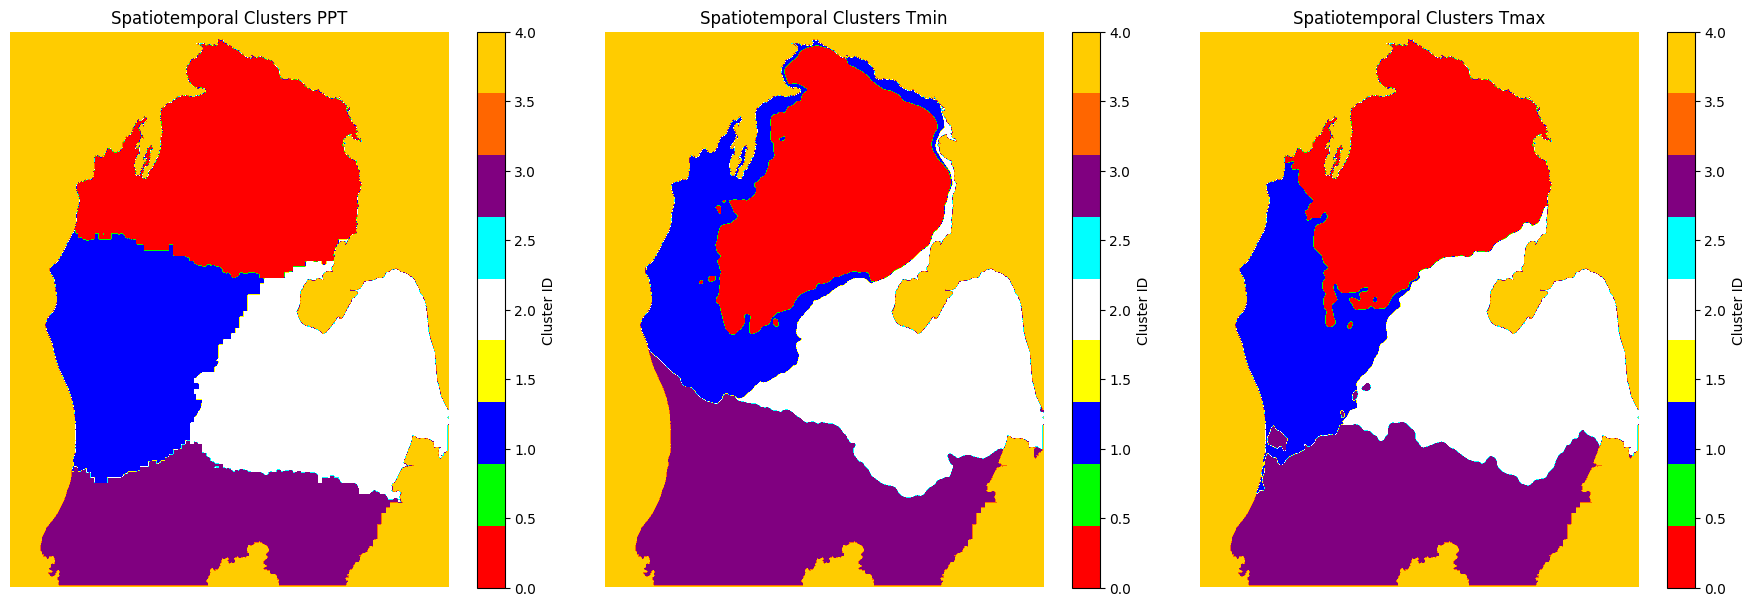

In [100]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap with 7 distinct colors
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FFFFFF', '#00FFFF', '#800080', '#FF6600', '#FFCC00']
cmap = mcolors.ListedColormap(colors)
# Reshape each cluster label array to (H, W)
ppt_cluster_np = ppt_labels_np.reshape(H, W)
tmin_cluster_np = tmin_labels_np.reshape(H, W)
tmax_cluster_np = tmax_labels_np.reshape(H, W)

# Create a single row of subplots (3 subplots side by side)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot each of the cluster maps
axes[0].imshow(ppt_cluster_np, cmap=cmap)
axes[0].set_title("Spatiotemporal Clusters PPT")
axes[0].axis("off")
fig.colorbar(axes[0].imshow(ppt_cluster_np, cmap=cmap), ax=axes[0], orientation='vertical', label="Cluster ID")

axes[1].imshow(tmin_cluster_np, cmap=cmap)
axes[1].set_title("Spatiotemporal Clusters Tmin")
axes[1].axis("off")
fig.colorbar(axes[1].imshow(tmin_cluster_np, cmap=cmap), ax=axes[1], orientation='vertical', label="Cluster ID")

axes[2].imshow(tmax_cluster_np, cmap=cmap)
axes[2].set_title("Spatiotemporal Clusters Tmax")
axes[2].axis("off")
fig.colorbar(axes[2].imshow(tmax_cluster_np, cmap=cmap), ax=axes[2], orientation='vertical', label="Cluster ID")

# Adjust the layout so it looks good
plt.tight_layout()
plt.show()


In [12]:
import torch
from kmeans_pytorch import kmeans
import random
# Assume ppt, tmin, and tmax are your tensors with shape [2695842, 365]
# Concatenate them along the feature dimension (columns)
combined_data = torch.cat((ppt_flat, tmin_flat, tmax_flat), dim=1)
print("Combined data shape:", combined_data.shape)  # Should be [2695842, 1095]

# Optional: Normalize or standardize your data here if needed.
# For example, you can subtract the mean and divide by the standard deviation for each feature.

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
combined_data = combined_data.to(device)

# Define the number of clusters
num_clusters = 5  # Change this number as needed

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Perform k-means clustering using kmeans_pytorch
cluster_ids, cluster_centers = kmeans(
    X=combined_data, 
    num_clusters=num_clusters, 
    distance='euclidean', 
    device=device
)

print("Clustering complete. Cluster IDs assigned for each data point:")
print(cluster_ids)


Combined data shape: torch.Size([2695842, 1095])
running k-means on cuda:0..


[running kmeans]: 13it [01:05,  5.05s/it, center_shift=0.000064, iteration=13, tol=0.000100]

Clustering complete. Cluster IDs assigned for each data point:
tensor([4, 4, 4,  ..., 4, 4, 4])


In [13]:
combined_data_labels_np = cluster_ids.cpu().numpy()  # back to NumPy if needed

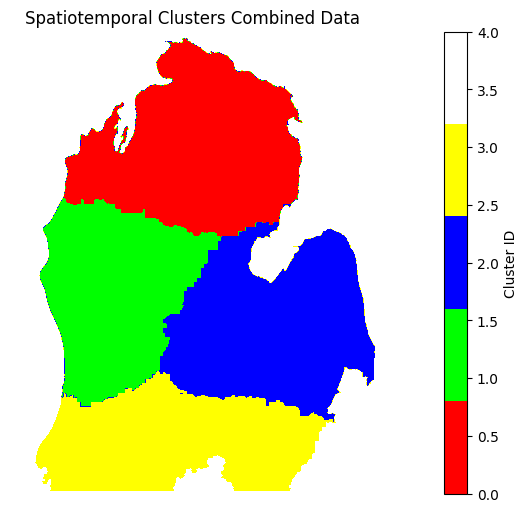

In [101]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap with 9 distinct colors
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FFFFFF']
cmap = mcolors.ListedColormap(colors)

# Reshape your cluster label array to (H, W)
# combined_data_cluster_np = combined_data_labels_np.reshape(H, W)

combined_data_cluster_np = ppt_cluster_np
# Create a single subplot
fig, ax = plt.subplots(figsize=(18, 6))

# Plot the cluster map
im = ax.imshow(combined_data_cluster_np, cmap=cmap)
ax.set_title("Spatiotemporal Clusters Combined Data")
ax.axis("off")
fig.colorbar(im, ax=ax, orientation='vertical', label="Cluster ID")

plt.show()


xres: 0.0030677582894121755, yres: 0.0022497684411030183


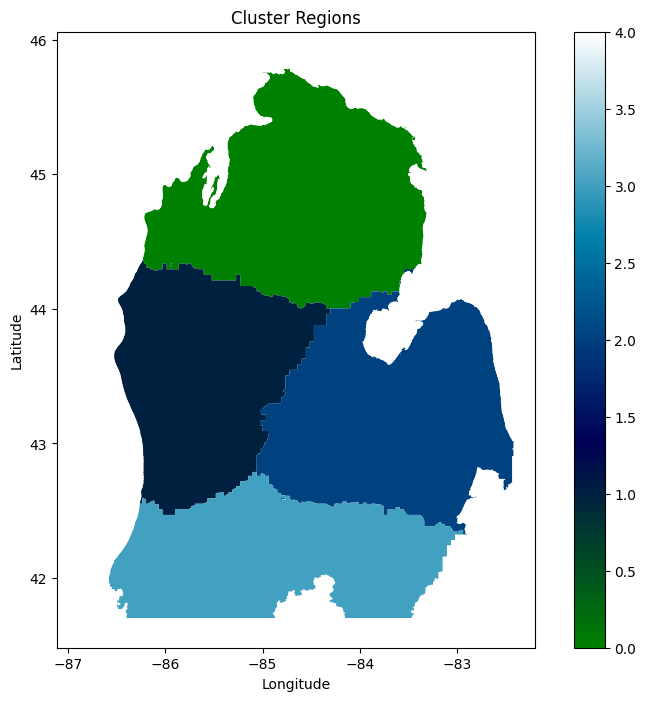

In [102]:
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
from affine import Affine
import rasterio.features

# Your provided geographic bounds and CRS
max_lon, min_lon = -82.4198362733253, -86.89262785928825
max_lat, min_lat = 45.850304369950784, 41.6904825223513
CRS = "EPSG:4326"

# Assume combined_data_cluster_np is your cluster label NumPy array of shape (H, W)
H, W = combined_data_cluster_np.shape

# Compute pixel resolution.
# Note: In this setup, we assume the top-left pixel of the array corresponds to (min_lon, max_lat).
# The x resolution is (max_lon - min_lon) divided by the number of columns,
# and the y resolution is (max_lat - min_lat) divided by the number of rows.
xres = (max_lon - min_lon) / W
yres = (max_lat - min_lat) / H
print(f"xres: {xres}, yres: {yres}")
# Create an affine transformation.
# The translation is set to the top-left corner (min_lon, max_lat) and we scale by xres and -yres (-yres because image rows increase downward).
transform = Affine.translation(min_lon, max_lat) * Affine.scale(xres, -yres)
# transform = Affine.translation(min_lon - xres / 2, max_lat + yres / 2) * Affine.scale(xres, -yres)

# Vectorize the raster (convert each contiguous region with the same cluster label to a polygon).
shapes_and_values = list(
    rasterio.features.shapes(combined_data_cluster_np.astype(np.int32), transform=transform)
)

# Extract geometries and their corresponding cluster IDs.
geoms = []
cluster_ids = []
for geom, value in shapes_and_values:
    geoms.append(shape(geom))
    cluster_ids.append(value)

# Create the GeoDataFrame with the specified CRS.
gdf = gpd.GeoDataFrame({'cluster_id': cluster_ids, 'geometry': geoms}, crs=CRS)

# Plot the GeoDataFrame
gdf.plot(column='cluster_id', cmap='ocean', legend=True, figsize=(10, 8))
plt.title("Cluster Regions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


/tmp/ipykernel_2876355/2377282614.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


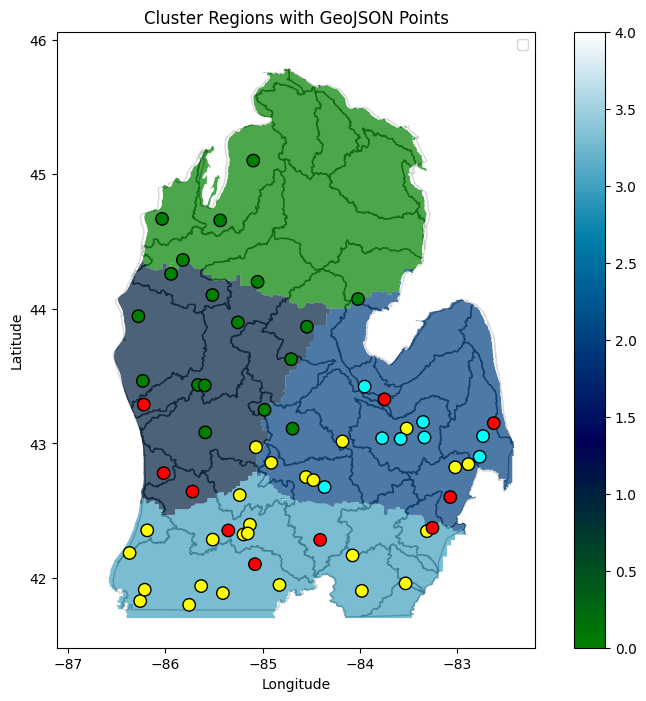

In [103]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Load your GeoDataFrames
geojson_path = '/home/talhamuh/water-research/CNN-LSMT/src/cnn_lstm_project/data_plots/clusters_points/4_gdf_points.geojson'
geojson_gdf = gpd.read_file(geojson_path)
shp_path = "/home/talhamuh/water-research/CNN-LSMT/data/raw/Michigan/Final_Michigan_Map/Watershed_Boundary_Intersect_Michigan.shp"
gdf_map = gpd.read_file(shp_path)
# Ensure both GeoDataFrames use the same CRS
gdf = gdf.to_crs("EPSG:4326")
geojson_gdf = geojson_gdf.to_crs("EPSG:4326")
gdf_map = gdf_map.to_crs("EPSG:4326")
# Plot the base layer (e.g., clusters)
ax = gdf.plot(column='cluster_id', cmap='ocean', legend=True, figsize=(10, 8), alpha=0.7, zorder=1)
# You can choose any 5 distinct colors. Here is an example:
custom_cmap = ListedColormap(['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink', 'cyan'])       
# Overlay the GeoJSON points on top of the base layer
geojson_gdf.plot(ax=ax, column='cluster', cmap=custom_cmap, markersize=80, edgecolor='k', legend=False)
gdf_map.plot(ax=ax, color='none', edgecolor='black', alpha=0.5, zorder=0)
# Customize plot labels and title
plt.title("Cluster Regions with GeoJSON Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

plt.show()


In [104]:
gdf

,cluster_id,geometry
0,4.0,"POLYGON ((-84.95687 45.75356, -84.95687 45.751..."
1,0.0,"POLYGON ((-84.43842 45.66132, -84.43842 45.659..."
2,0.0,"POLYGON ((-84.97221 45.41835, -84.97221 45.416..."
3,0.0,"POLYGON ((-85.01516 45.36435, -85.01516 45.362..."
4,4.0,"POLYGON ((-85.00902 45.36435, -85.00902 45.362..."
5,0.0,"POLYGON ((-83.62547 45.35311, -83.62547 45.350..."
6,4.0,"POLYGON ((-83.4506 45.27886, -83.4506 45.27436..."
7,0.0,"POLYGON ((-85.53361 45.14613, -85.53361 45.137..."
8,0.0,"POLYGON ((-83.3555 45.10788, -83.3555 45.10563..."
9,0.0,"POLYGON ((-83.3463 45.09213, -83.3463 45.08988..."


In [105]:
geojson_gdf

,site_number,cluster,longitude,latitude,geometry
0,4099000,2,-85.756105,41.800883,POINT (-85.7561 41.80088)
1,4101500,2,-86.259732,41.829214,POINT (-86.25973 41.82921)
2,4097540,2,-85.409428,41.888383,POINT (-85.40943 41.88838)
3,4176000,2,-83.980776,41.904769,POINT (-83.98078 41.90477)
4,4097500,2,-85.632771,41.940326,POINT (-85.63277 41.94033)
...,...,...,...,...,...
56,4148140,3,-83.581342,43.033638,POINT (-83.58134 43.03364)
57,4115000,1,-84.693052,43.109755,POINT (-84.69305 43.10975)
58,4159492,0,-82.624647,43.150860,POINT (-82.62465 43.15086)
59,4121944,1,-85.595599,43.430858,POINT (-85.5956 43.43086)


In [106]:
import geopandas as gpd
import pandas as pd
import itertools

# Ensure both GeoDataFrames use the same CRS
region_clusters_gdf = gdf.to_crs("EPSG:4326")
points_gdf = geojson_gdf.to_crs("EPSG:4326")

# 1. Compute total count of points for each point cluster (from the points GeoDataFrame)
total_counts = (
    points_gdf.groupby("cluster")
    .size()
    .reset_index(name="total_count")
)
# total_counts now has two columns: 'cluster' and 'total_count'

# 2. Spatial join: determine which points fall inside which region polygon.
# This join will only include points that fall within a region.
joined = gpd.sjoin(points_gdf, region_clusters_gdf, how="inner", predicate="within")

# 3. For each region cluster (from the polygons) and each point cluster (from points),
# count the number of points that fall within that region.
region_counts = (
    joined.groupby(["cluster_id", "cluster"])
    .size()
    .reset_index(name="count_in_region")
)

# 4. Create a cartesian product of all unique region cluster IDs and all unique point clusters.
region_ids = region_clusters_gdf["cluster_id"].unique()
point_clusters = points_gdf["cluster"].unique()

cartesian = pd.DataFrame(
    list(itertools.product(region_ids, point_clusters)),
    columns=["cluster_id", "cluster"]
)

# 5. Merge the cartesian product with the counts from the spatial join.
# Missing combinations (where a region captured zero points of a given point cluster) will be filled with 0.
merged = pd.merge(cartesian, region_counts, on=["cluster_id", "cluster"], how="left")
merged["count_in_region"] = merged["count_in_region"].fillna(0)

# 6. Merge in the total point counts for each point cluster.
merged = pd.merge(merged, total_counts, on="cluster", how="left")

# 7. Compute the error for each combination.
# Formula: (total_count - count_in_region) / total_count
merged["error"] = (merged["total_count"] - merged["count_in_region"]) / merged["total_count"]
# Filter out region clusters (cluster_id) with all count_in_region == 0
merged = merged.groupby('cluster_id').filter(lambda grp: grp['count_in_region'].sum() > 0)
# 8. Display the results
merged


,cluster_id,cluster,count_in_region,total_count,error
4,0.0,2,0.0,25,1.000000
5,0.0,0,0.0,10,1.000000
6,0.0,3,0.0,8,1.000000
7,0.0,1,6.0,18,0.666667
8,1.0,2,1.0,25,0.960000
9,1.0,0,3.0,10,0.700000
10,1.0,3,0.0,8,1.000000
11,1.0,1,10.0,18,0.444444
12,2.0,2,7.0,25,0.720000
13,2.0,0,3.0,10,0.700000
